# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

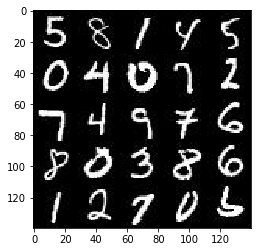

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

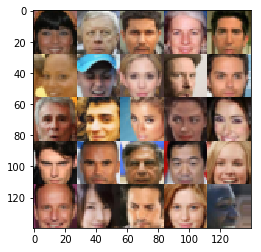

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/home/polo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # real input of the model
    input_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    # z input of the model
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    # learning rate of the model
    l_rate = tf.placeholder(tf.float32,name="l_rate")
    
    return input_real, input_z, l_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
import numpy as np
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    stddev = 0.02

    lrelu = lambda x: tf.maximum(alpha*x, x)
    # discriminator neural network 
    def conv(x, d, bn=True):
        x = tf.layers.conv2d(x, d, 5,
                             strides=2,
                             padding="same",
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        if bn:
            x = tf.layers.batch_normalization(x, training=True)
            return lrelu(x)
        else:
            return lrelu(x)
        
    # reuse variables in the neural network
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # set input layer 28x28xc
        x = conv(images, 64) # 14x14x64
        x = conv(x, 128)     # 7x7x128
        x = conv(x, 256)     # 4x4x256
        x = conv(x, 512)     # 2x2x512

        # flatten 
        logits = tf.layers.dense(
            tf.reshape(x, (-1, np.prod(x.get_shape().as_list()[1:]))), 1,kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        logits = tf.nn.dropout(logits, 0.5)
        out = tf.sigmoid(logits)

        return out, logits    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    stddev = 0.02
    
    lrelu = lambda x: tf.maximum(alpha*x, x)
    # create generator network
    with tf.variable_scope('generator', reuse = not is_train):
        x1 = tf.layers.dense(z, 2*2*512)
        
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
       
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='valid',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))

        out = tf.tanh(logits)
       
    return out 



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # TODO: Implement Function
    
    # return discriminator and generator loss
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*np.random.uniform(0.7,1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*np.random.uniform(0.7,1.2)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # get weights and bias update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # optimize function 
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)   
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,print_every=100, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    
    # set input 
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples = []
    losses = []
    
    # training
    with tf.Session() as sess:        
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            i = 0
            for batch_images in get_batches(batch_size):
                i += 1
                # TODO: Train Model
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))            
                # run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z,l_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,l_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,l_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,l_rate:learning_rate})
                
                # for 100 batches show output
                if i % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                # print loss every epoch 
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
                if i % 10 == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))    
                    # save loss
                    losses.append((train_loss_d, train_loss_g))

                    # sample from generator 
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_real: batch_images, input_z: sample_z,l_rate:learning_rate})
                    samples.append(gen_samples)
        show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)    

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.8280
Epoch 1/2... Discriminator Loss: 1.5285... Generator Loss: 0.7368
Epoch 1/2... Discriminator Loss: 1.4283... Generator Loss: 0.4961
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 1.2675
Epoch 1/2... Discriminator Loss: 1.0727... Generator Loss: 0.9700
Epoch 1/2... Discriminator Loss: 1.8145... Generator Loss: 0.5176
Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 1.1197
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 1.0284... Generator Loss: 1.0734


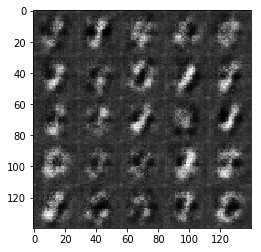

Epoch 1/2... Discriminator Loss: 0.9044... Generator Loss: 0.6247
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 1.2715
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 1.3259
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 0.7942
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 0.7095
Epoch 1/2... Discriminator Loss: 1.6993... Generator Loss: 1.9798
Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.4201... Generator Loss: 0.6087
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 0.6401
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.8986


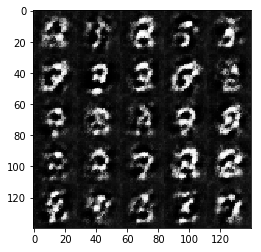

Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 0.9698
Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 0.9677
Epoch 1/2... Discriminator Loss: 1.0872... Generator Loss: 0.7681
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 0.5446
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 1.3254
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 1.6636
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.5924
Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 0.6977
Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 0.5841


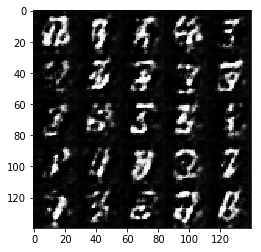

Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 0.6444
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 0.8412
Epoch 1/2... Discriminator Loss: 1.1580... Generator Loss: 1.1411
Epoch 1/2... Discriminator Loss: 1.0729... Generator Loss: 0.6383
Epoch 1/2... Discriminator Loss: 0.7924... Generator Loss: 1.4685
Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 0.6299
Epoch 1/2... Discriminator Loss: 1.1914... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 0.6936


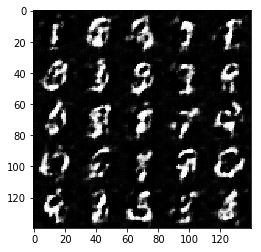

Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 0.5434
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.1712... Generator Loss: 0.6167
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.6001
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 0.5399
Epoch 1/2... Discriminator Loss: 1.1539... Generator Loss: 0.7512
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 0.6125
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 1.4743... Generator Loss: 0.5506
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.5703


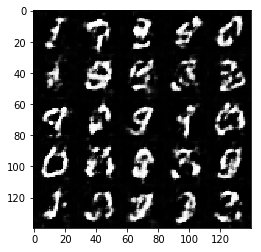

Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 1.1506
Epoch 1/2... Discriminator Loss: 1.1890... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.5169
Epoch 1/2... Discriminator Loss: 1.5664... Generator Loss: 0.5376
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.6720
Epoch 1/2... Discriminator Loss: 1.0264... Generator Loss: 1.0271
Epoch 1/2... Discriminator Loss: 1.4588... Generator Loss: 0.5309
Epoch 1/2... Discriminator Loss: 0.9596... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.6437... Generator Loss: 0.5515
Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 0.5447


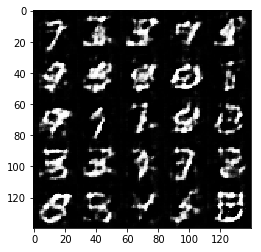

Epoch 1/2... Discriminator Loss: 1.2938... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 0.7886... Generator Loss: 1.4152
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 0.7511
Epoch 1/2... Discriminator Loss: 1.1751... Generator Loss: 0.5937
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.5527
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 0.6070
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.9916


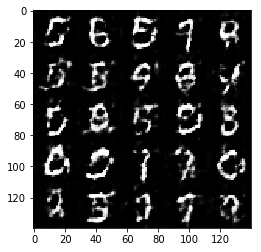

Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 0.6399
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.5777
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 0.5750
Epoch 1/2... Discriminator Loss: 1.3191... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 0.5876
Epoch 1/2... Discriminator Loss: 1.5832... Generator Loss: 0.5020
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 1.1010
Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 0.5084
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 0.7339


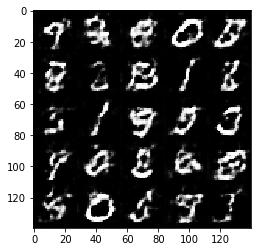

Epoch 1/2... Discriminator Loss: 1.4356... Generator Loss: 0.6279
Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 0.6558
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.6216
Epoch 1/2... Discriminator Loss: 1.5210... Generator Loss: 0.5721
Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 0.8744
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.5503
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 0.5427
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.7798
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 0.4966


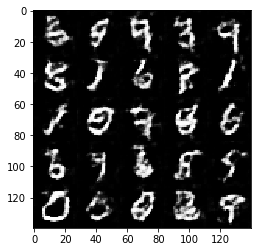

Epoch 1/2... Discriminator Loss: 1.4960... Generator Loss: 0.5576
Epoch 1/2... Discriminator Loss: 1.2073... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.4798... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 0.7537
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.9832
Epoch 1/2... Discriminator Loss: 1.5690... Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.5236
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.6563
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.6060
Epoch 1/2... Discriminator Loss: 1.2413... Generator Loss: 0.7053


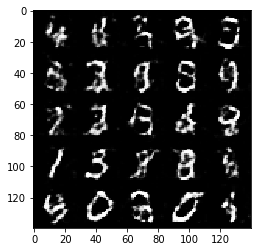

Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 0.5837
Epoch 1/2... Discriminator Loss: 1.5431... Generator Loss: 0.6947
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 1.1751
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.6210
Epoch 1/2... Discriminator Loss: 1.6965... Generator Loss: 0.5561
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.6625
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.5158
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.5389


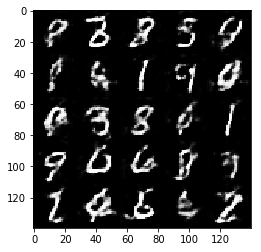

Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.5567
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.9672
Epoch 1/2... Discriminator Loss: 1.0829... Generator Loss: 0.8447
Epoch 1/2... Discriminator Loss: 1.2650... Generator Loss: 0.6532
Epoch 1/2... Discriminator Loss: 1.5949... Generator Loss: 0.6078
Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.6168... Generator Loss: 0.6150
Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 0.8789


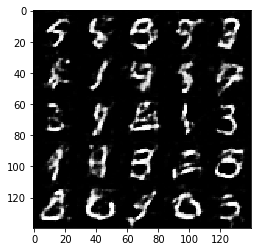

Epoch 1/2... Discriminator Loss: 1.5885... Generator Loss: 0.5512
Epoch 1/2... Discriminator Loss: 1.2117... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 1.3291... Generator Loss: 0.7444
Epoch 1/2... Discriminator Loss: 1.4967... Generator Loss: 0.5648
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 0.6353
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.5737
Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 0.5671
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.7898


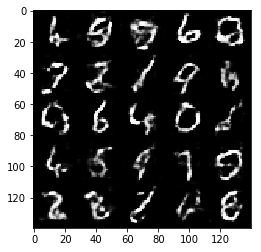

Epoch 1/2... Discriminator Loss: 1.6630... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 1.6633... Generator Loss: 1.1124
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 0.5450
Epoch 1/2... Discriminator Loss: 1.6462... Generator Loss: 0.5207
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.5787
Epoch 1/2... Discriminator Loss: 1.5204... Generator Loss: 0.4938
Epoch 1/2... Discriminator Loss: 1.5197... Generator Loss: 0.4949
Epoch 1/2... Discriminator Loss: 1.4314... Generator Loss: 0.6165
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 0.6607


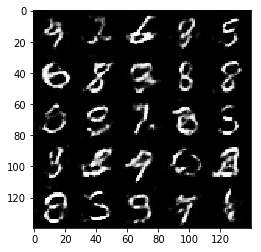

Epoch 1/2... Discriminator Loss: 1.6039... Generator Loss: 0.5817
Epoch 1/2... Discriminator Loss: 1.7757... Generator Loss: 0.9974
Epoch 1/2... Discriminator Loss: 1.6068... Generator Loss: 0.4669
Epoch 1/2... Discriminator Loss: 1.4624... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.1471... Generator Loss: 0.5684
Epoch 1/2... Discriminator Loss: 1.7165... Generator Loss: 0.5148
Epoch 1/2... Discriminator Loss: 1.0222... Generator Loss: 0.8354
Epoch 1/2... Discriminator Loss: 1.7761... Generator Loss: 0.5504
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 1.4088
Epoch 1/2... Discriminator Loss: 1.7169... Generator Loss: 0.5679


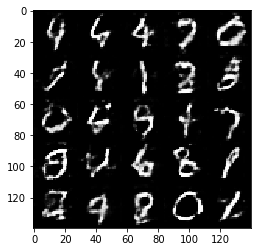

Epoch 1/2... Discriminator Loss: 1.6769... Generator Loss: 0.4679
Epoch 1/2... Discriminator Loss: 1.1347... Generator Loss: 1.3181
Epoch 1/2... Discriminator Loss: 1.5988... Generator Loss: 0.4998
Epoch 1/2... Discriminator Loss: 1.6291... Generator Loss: 0.5897
Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.6397
Epoch 1/2... Discriminator Loss: 1.3924... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.6210


KeyboardInterrupt: 

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3
alpha = 0.1

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 2.4793... Generator Loss: 0.4528
Epoch 1/1... Discriminator Loss: 1.7234... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 1.8565
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 1.3956
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 1.6486


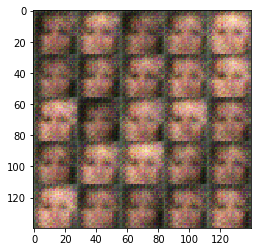

Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.6559... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.7055


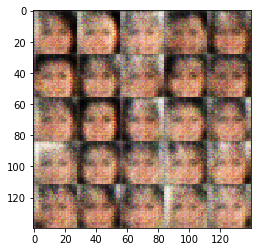

Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 1.4718
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7443


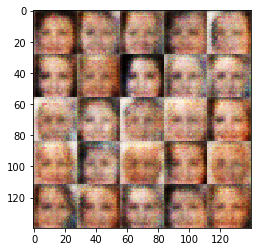

Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.5810
Epoch 1/1... Discriminator Loss: 1.5682... Generator Loss: 0.5996


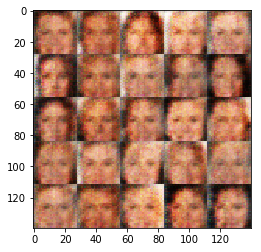

Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.4956... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 1.1265


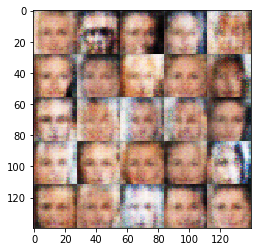

Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8323


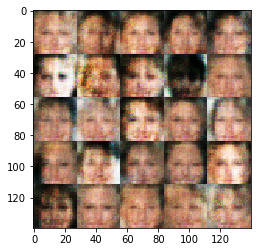

Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 1.0870


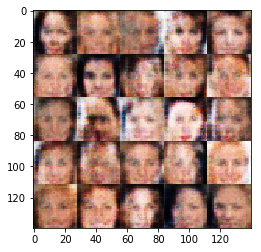

Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.8545


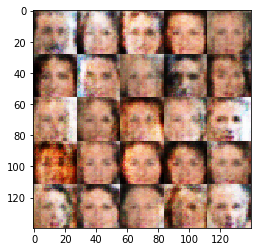

Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8353


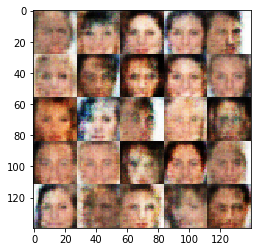

Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.8513


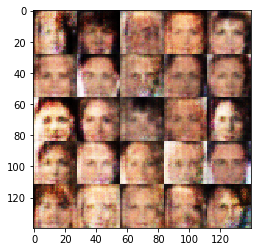

Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.8596


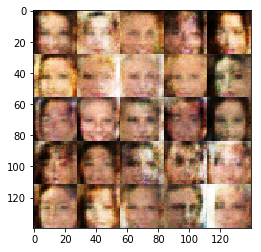

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7896


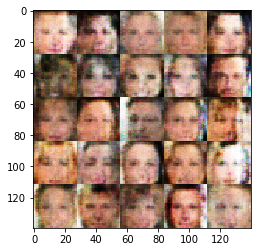

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8670


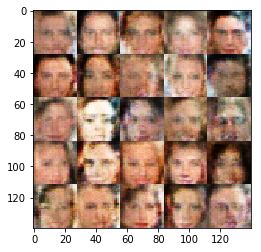

Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8689


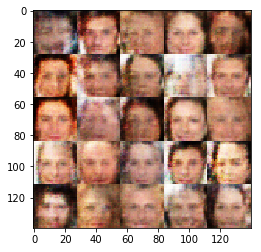

Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.8274


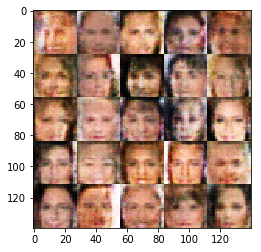

Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.9351


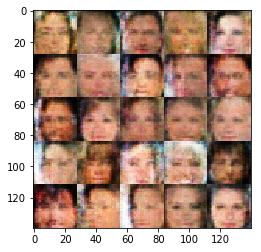

Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.8709


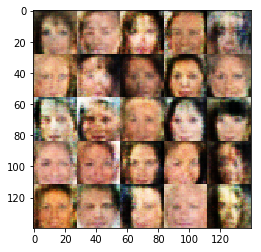

Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.9618


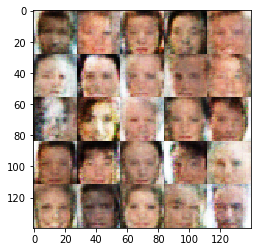

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.8395


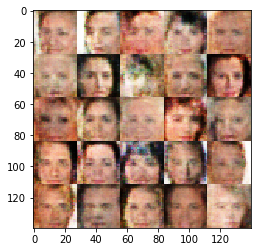

Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 1.0465


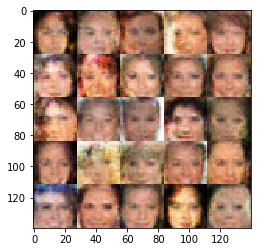

Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7039


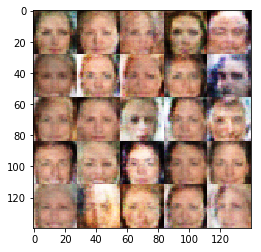

Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8534


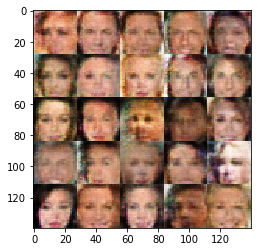

Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8300


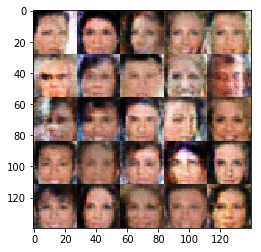

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8431


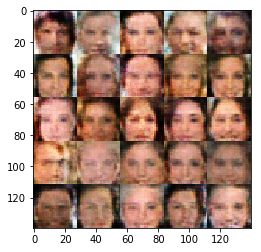

Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.8109


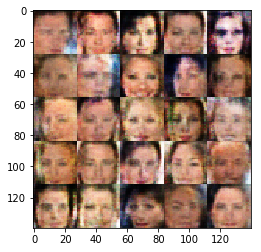

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8243


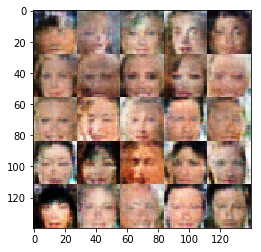

Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6905


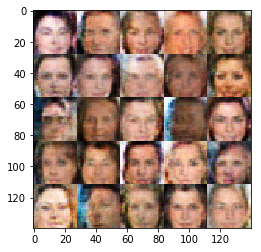

Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7495


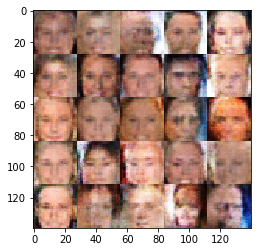

Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8013


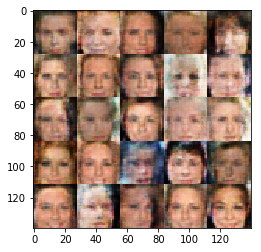

Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8110


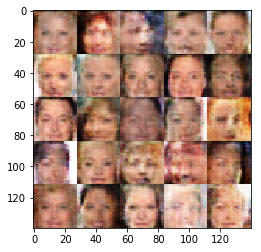

Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.9187


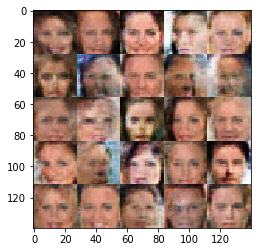

Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8847


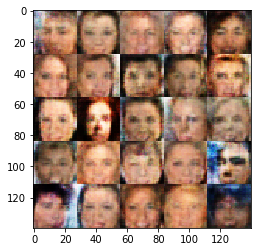

Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8374


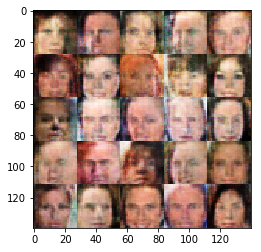

Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8514


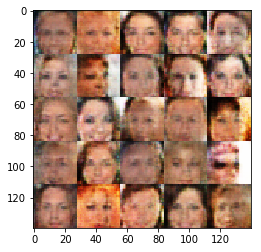

Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8778


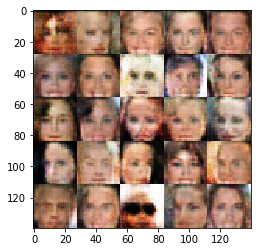

Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.8196


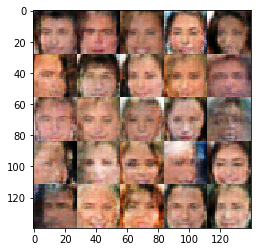

Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.9462


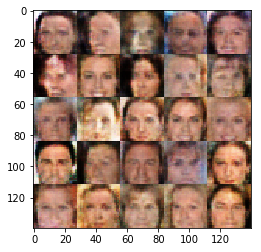

Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 1.0052


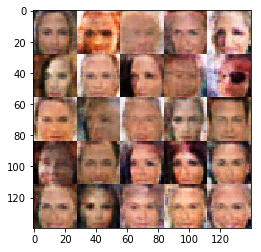

Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.8139


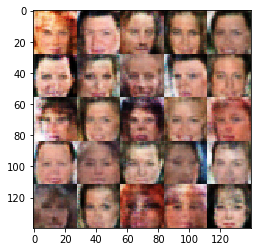

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.9437


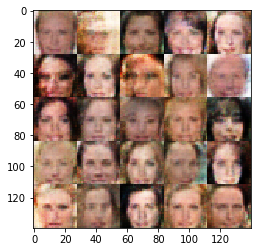

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8477


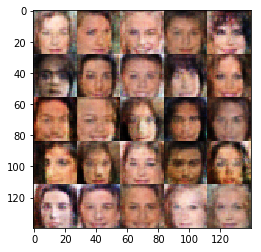

Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7669


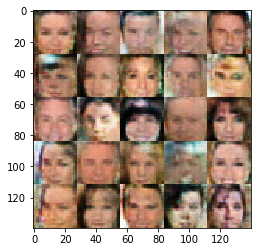

Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.9977
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.9326


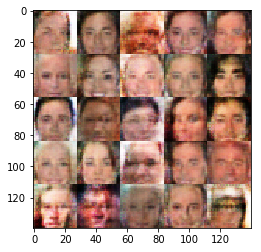

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.8181


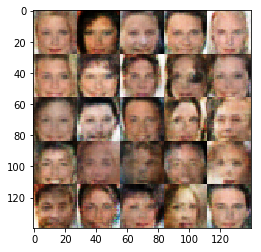

Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7537


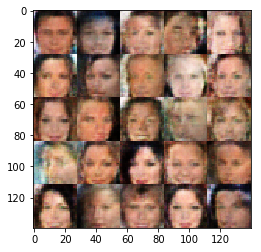

Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.9100


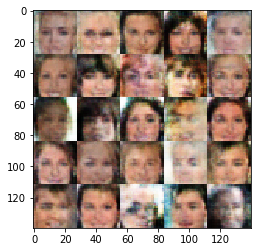

Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.8389


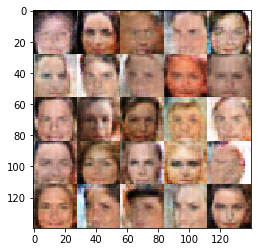

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7826


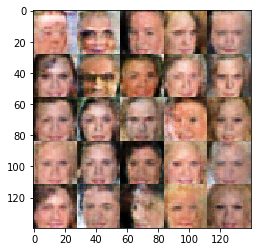

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.8326


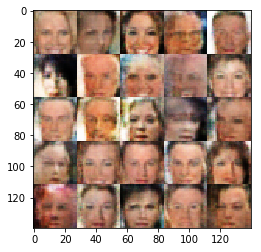

Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.9392
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8107


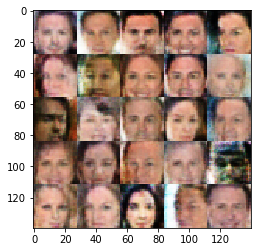

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8018


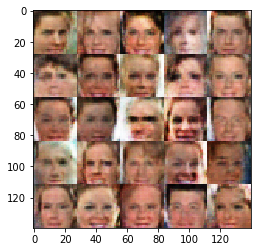

Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.8426


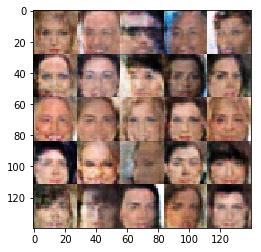

Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8966


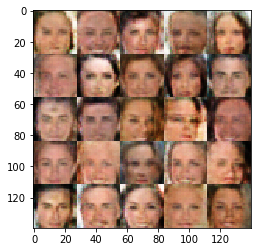

Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7957


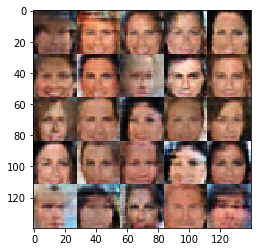

Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.8638


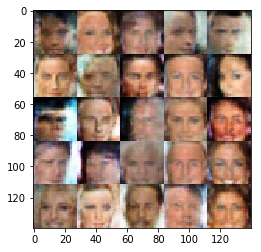

Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8684


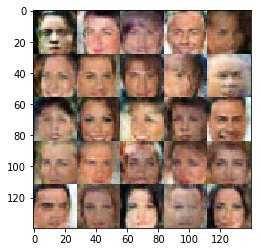

Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.9147


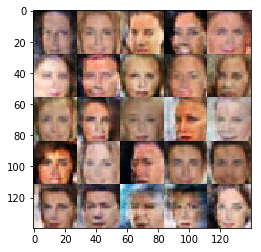

Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.9011


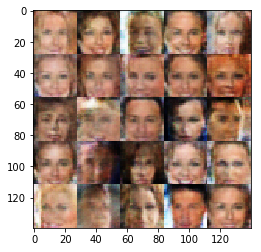

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7805


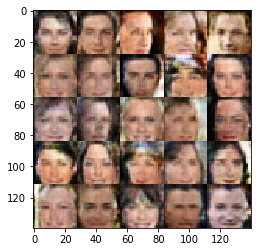

Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6627


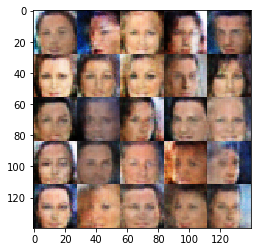

Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.9568


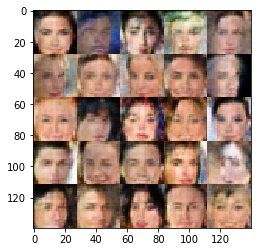

Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.9849
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.9348


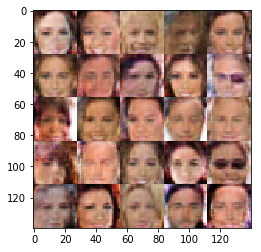

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7552


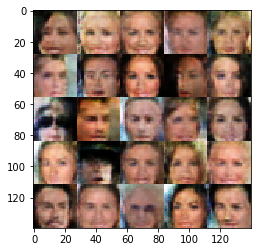

Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8495


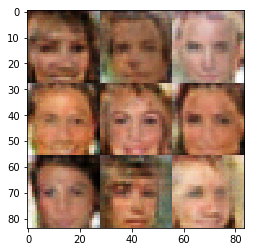

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3
alpha = 0.1

tf.reset_default_graph()



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.